In [42]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Add 

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
from keras.layers import *
%matplotlib inline


In [53]:

import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
import Utility
import cv2
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

# Loading normal and segmented images

In [48]:
trainList = ["all_images","Ground_truth\gt"]

class_id = 0
images_path = []
segs_path = []


for training_name in trainList:
    class_path = Utility.imlist(training_name)
    if(class_id != 1 ):
        images_path += class_path
    if(class_id == 1):
        segs_path+=class_path
    class_id += 1
    
    
img_path = []
for img in images_path:
    img_p = img.split("\\")[1]
    img_path.append(img_p)

seg_path = []
for seg in segs_path:
    segi = seg.split("\\")[2]
    seg_path.append(segi)

img_path.sort()
seg_path.sort()    

# Preprocessing to get the desired images of size(256,256)

In [56]:
imgs = []
labels = []
n_labels = 2
path = "all_images\\"
for i in range(2000):
    original_img = cv2.imread(path+img_path[i])
    array_img = cv2.resize(original_img, (256,256))
    array_img = img_to_array(array_img)/255
    #array_img = np.rollaxis(array_img, 2, 0)
    imgs.append(array_img)

    
    
dims = (256,256)
path2 = "Ground_truth\\gt\\"
for i in range(2000):
    if(i%50 == 0):
        print(i)
    
    original_mask = cv2.imread(path2 + seg_path[i],0)
    #print(original_mask.shape)
    resized_mask = cv2.resize(original_mask, (dims[0], dims[1]))
    ret,image = cv2.threshold(resized_mask,127,255,cv2.THRESH_BINARY)
    #print(np.amax(resized_mask))
    #array_mask = binarylab(resized_mask[:, :, 0], dims, n_labels)
    labels.append(image)   
    
imgs = np.array(imgs)
labels = np.array(labels)



labelss = labels.reshape(labels.shape[0],256,256,1)
#np.save('total_images.npy',imgs)
#np.save('ground_truth_resized.npy',labelss)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [ ]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

# Unet Architecture For Segmentation

In [43]:
def get_unet1(patch_height,patch_width,n_ch):
    concat_axis = 3

    inputs = Input((patch_height, patch_width, n_ch))
    
    conv1 = Conv2D(32, (3, 3), padding="same", name="conv1_1", activation="relu", data_format="channels_last")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv5)

    up_conv5 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv4)
    up6   = concatenate([up_conv5, crop_conv4], axis=concat_axis)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv6)

    up_conv6 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv3)
    up7   = concatenate([up_conv6, crop_conv3], axis=concat_axis)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv7)

    up_conv7 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv2)
    up8   = concatenate([up_conv7, crop_conv2], axis=concat_axis)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv8)

    up_conv8 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv1)
    up9   = concatenate([up_conv8, crop_conv1], axis=concat_axis)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv9)

    outputs = Conv2D(1, (1, 1), data_format="channels_last", activation="sigmoid")(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model
    
model = get_unet1(256,256,3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 32) 9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 

In [6]:
x = np.load('total_images.npy')
y = np.load('ground_truth_resized.npy')
print(x.shape)
print(y.shape)

(2000, 256, 256, 3)
(2000, 256, 256)


# Divide Training  and Testing Data

In [37]:
train_i = np.random.choice(2000,1500,replace = False)

x_train = []
y_train = [] 
for i in train_indices:
    x_train.append(x[i])
    y_train.append(y[i])

test_i = [x for x in range(2000) if x not in train_i]

x_test = []
y_test = []

for i in test_indices:
    x_test.append(x[i])
    y_test.append(y[i])

In [8]:
x_train = np.array(x_train_images)
x_test = np.array(x_test_images)
y_train = np.array(y_train_labels)
y_test = np.array(y_test_labels)


# Define dice_coefficient function

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [16]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [17]:
def customized_loss(y_true,y_pred):
    return (1*K.binary_crossentropy(y_true, y_pred))+(0.5*dice_coef_loss(y_true, y_pred))

# Train the Model

In [20]:
y_train = y_train.reshape(y_train.shape[0],256,256,1)
y_test = y_test.reshape(y_test.shape[0],256,256,1)
smooth = 1
optimiser = optimizers.Adam(lr = 0.01)


model.compile(optimizer=optimiser,loss=dice_coef_loss,metrics=['accuracy',dice_coef])
model.fit(x_train,y_train,batch_size=8,epochs=200,validation_data=(x_test, y_test),verbose=1)

Train on 1500 samples, validate on 500 samples
Epoch 1/200
1500/1500 [==============================] - 9371s 6s/step - loss: -0.5385 - acc: 0.8390 - dice_coef: 0.6030 - val_loss: -0.3078 - val_acc: 0.5288 - val_dice_coef: 0.4275
Epoch 2/200
1500/1500 [==============================] - 10408s 7s/step - loss: -0.6541 - acc: 0.8983 - dice_coef: 0.7208 - val_loss: -0.3374 - val_acc: 0.8618 - val_dice_coef: 0.3809
Epoch 3/200
1500/1500 [==============================] - 9966s 7s/step - loss: -0.7279 - acc: 0.9129 - dice_coef: 0.7627 - val_loss: -0.5064 - val_acc: 0.8872 - val_dice_coef: 0.5435
Epoch 4/200
1500/1500 [==============================] - 9051s 6s/step - loss: -0.7447 - acc: 0.9189 - dice_coef: 0.7762 - val_loss: -0.3624 - val_acc: 0.8585 - val_dice_coef: 0.3861
Epoch 5/200
1500/1500 [==============================] - 8945s 6s/step - loss: -0.7699 - acc: 0.9261 - dice_coef: 0.7977 - val_loss: -0.6695 - val_acc: 0.9141 - val_dice_coef: 0.6895
Epoch 6/200
1500/1500 [==============

KeyboardInterrupt: 

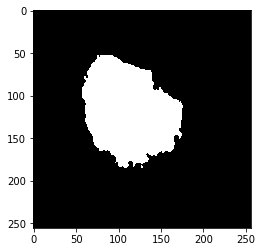

In [33]:
gt = y_test[5].reshape((256,256))

plt.imshow(gt,cmap='gray')

In [34]:
test = x_test[5].reshape((1,256,256,3))
pred = model.predict(test)

In [35]:
gt_pred = pred.reshape((256,256))

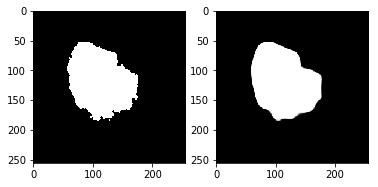

In [36]:
plt.subplot(1,2,1)
plt.imshow(gt, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(gt_pred, cmap = "gray")